In [49]:
from DatasetGenerator import *
from helpers import *
from markov_algos import *
from plots import *

import numpy as np
import pandas as pd
from time import time

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tuning of parameters

We evaluate the best `starting_state`

In [ ]:
lambdas = [0.5,1]

n_best_approx = np.zeros([len(lambdas),3])
count_equivalence = np.zeros([len(lambdas),4])

n_istances = 30
for l,lambda_ in enumerate(lambdas):
    for _ in range(n_istances):
        data = G1()  
        n_iter = 10000
        betas = np.logspace(0, 3, 7)
        starting_states = [np.random.randint(low=0, high=2, size=data.N), np.zeros(data.N), np.ones(data.N)]
        starting_states[1][ datas[k].v == np.max(datas[k].v)] = 1
        maxs_f_approx = np.zeros(3)
    
        for i, starting_state in enumerate(starting_states):
            S_approx = simulated_annealing(starting_state, betas, n_iter, lambda_, data, verbose=False)
            maxs_f_approx[i] = f(S_approx, lambda_, data)
        max_f_approx = max(maxs_f_approx)
        count = 0
        for i, max_f_approx_i in enumerate(maxs_f_approx):
            if max_f_approx_i==max_f_approx:
                n_best_approx[l,i] += 1
                count +=1
        count_equivalence[l,count] +=1

In [ ]:
starting_states = ['random', 'crowded_city', 'ones']
for l, lambda_ in enumerate(lambdas):
    print('\n\nFor Lambda = {}'.format(lambda_))
    for i in range(3):
        print('Using starting_state={} we get the best approx max of f {:.1%} of times'.format(starting_states[i],n_best_approx[l,i]/n_istances))
    
    print('The best approximated solution is the same for all the 3 starting_states {:.1%} of times'.format(count_equivalence[l,3]/n_istances) )
    print('The best approximated solution is the same only for 2 starting_states {:.1%} of times'.format(count_equivalence[l,2]/n_istances) )
    print('The best approximated solution is the unique among the three starting_states {:.1%} of times'.format(count_equivalence[l,1]/n_istances) ) 

We fix the total number of iterations to be `total_n_iter = 1 000 000`, `lambda = 0.5` and using the generator of istances G1 we tune $\max \beta$ (`max_beta`) and the number of  $\beta$ (`nb_beta`).

In [3]:
datas = [G1() for i in range(3)]

lambda_ = 0.5
total_n_iter = 1000000

max_beta = [3, 4, 5] # 10-th power
nb_beta = [5, 7, 10, 13]
n_iter_range = [total_n_iter // b_nb for b_nb in nb_beta]

df = pd.DataFrame(columns=['max beta', 'nb beta', 'avg max obj', 'avg size of S'])

for b_max in max_beta:
    for i, b_nb in enumerate(nb_beta):
        betas = np.logspace(0, b_max, b_nb)
        n_iter = n_iter_range[i]

        avg_obj, avg_size = avg(datas, betas, lambda_, n_iter)
        res = {'max beta':int(b_max), 'nb beta':int(b_nb), 'avg max obj':round(avg_obj,2), 'avg size of S':round(avg_size,1)}
        df = df.append(res, ignore_index=True)

df.to_csv('plots/betas.csv', index=False)
df

Wall time: 1h 24min 15s


,max beta,nb beta,avg max obj,avg size of S
0,3.0,5.0,4.614770,37.666667
1,3.0,7.0,5.093564,49.000000
2,3.0,10.0,3.595260,79.333333
3,3.0,13.0,4.522376,64.333333
4,4.0,5.0,3.583713,57.000000
5,4.0,7.0,3.787064,34.666667
6,4.0,10.0,4.720011,48.000000
7,4.0,13.0,4.015628,37.333333
8,5.0,5.0,3.743526,40.666667
9,5.0,7.0,3.462299,62.333333


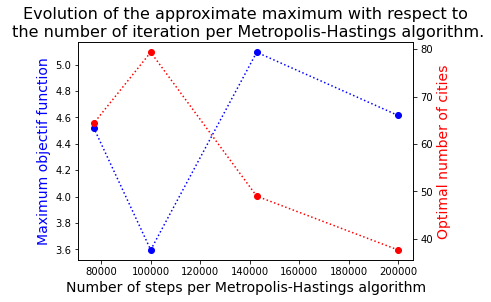

In [51]:
best_obj = max(df.iloc[:,2])
best_max_beta = df[df['avg max obj'] == best_obj].iloc[:,0].tolist()[0]
best_nb_beta = int(df[df['avg max obj'] == best_obj].iloc[:,1].tolist()[0])

obj_range = df[df['max beta'] == best_max_beta].iloc[:,2].tolist()
size_range = df[df['max beta'] == best_max_beta].iloc[:,3].tolist()

fig, ax = plt.subplots()
ax.plot(n_iter_range, obj_range, color='blue', marker='o', ls=':')
ax2 = ax.twinx()
ax2.plot(n_iter_range, size_range, color='red', marker='o', ls=':')

ax.set_title("Evolution of the approximate maximum with respect to"
             + "\n the number of iteration per  betas inMetropolis-Hastings algorithm.", fontsize=16)
ax.set_xlabel("Number of steps per Metropolis-Hastings algorithm", fontsize=14)
ax.set_ylabel("Maximum objectif function", color='blue', fontsize=14)
ax2.set_ylabel("Optimal number of cities", color='red', fontsize=14)
plt.show()

In [59]:
# parameters
n_iter = total_n_iter // best_nb_beta
betas = np.logspace(0, best_max_beta, best_nb_beta)

# Simple Instances

In [72]:
def testing_metropolis(data, betas, lambda_, n_iter):
    n, coords, pop = data.N, data.x, data.v
    
    starting_state = np.zeros(n)
    #starting_state[ pop == np.max(pop)] = 1
    S_approx = simulated_annealing(starting_state, betas, n_iter, lambda_, data, verbose=False)
    
    print('S~:', S_approx)
    print('size of S~:', len(S_approx))
    print('f(S~) = ',f(S_approx, lambda_, data))

We evaluate our algorithm on with `lambda`=0.  For this simple instance we know that S* is equal to the whole set of cites. Our model solve exactly this special case.

In [74]:
data = G1()  
lambda_ = 0

testing_metropolis(data, betas, lambda_, n_iter)

[step 1/7] Time spent on beta = 1.000 : 0.040 sec
[step 2/7] Time spent on beta = 3.162 : 0.032 sec
[step 3/7] Time spent on beta = 10.000 : 0.026 sec
[step 4/7] Time spent on beta = 31.623 : 0.033 sec
[step 5/7] Time spent on beta = 100.000 : 0.031 sec
[step 6/7] Time spent on beta = 316.228 : 0.031 sec
[step 7/7] Time spent on beta = 1000.000 : 0.031 sec
S~: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
size of S~: 100
f(S~) =  46.58867373557657


We evaluate our algorithm on with `lambda`=10000.  We expect that the size of S~ would be small if it is equal to 1 S~ would be he most crowded city. Our expectation are confirmed.

In [73]:
data = G1()  
lambda_ = 10000

most_crowded_city = np.argwhere(data.v == np.max(data.v))[0][0]
print('most crowded city:', most_crowded_city)
print('f(most crowded city) = '.format(f([most_crowded_city], lambda_, data)))

testing_metropolis(data, betas, lambda_, n_iter)

most crowded city: 32
f(most crowded city) = 
[step 1/7] Time spent on beta = 1.000 : 0.027 sec
[step 2/7] Time spent on beta = 3.162 : 0.016 sec
[step 3/7] Time spent on beta = 10.000 : 0.016 sec
[step 4/7] Time spent on beta = 31.623 : 0.018 sec
[step 5/7] Time spent on beta = 100.000 : 0.000 sec
[step 6/7] Time spent on beta = 316.228 : 0.016 sec
[step 7/7] Time spent on beta = 1000.000 : 0.016 sec
S~: [32]
size of S~: 1
f(S~) =  0.9946554249567496


# Ploting the evolution of the Markov chain during the simulated annealing process (with G1, Q2.a)

[step 1/7] Time spent on beta = 1.000 : 24.869 sec
[step 2/7] Time spent on beta = 3.162 : 23.886 sec
[step 3/7] Time spent on beta = 10.000 : 25.775 sec
[step 4/7] Time spent on beta = 31.623 : 26.865 sec
[step 5/7] Time spent on beta = 100.000 : 25.755 sec
[step 6/7] Time spent on beta = 316.228 : 25.412 sec
[step 7/7] Time spent on beta = 1000.000 : 24.927 sec


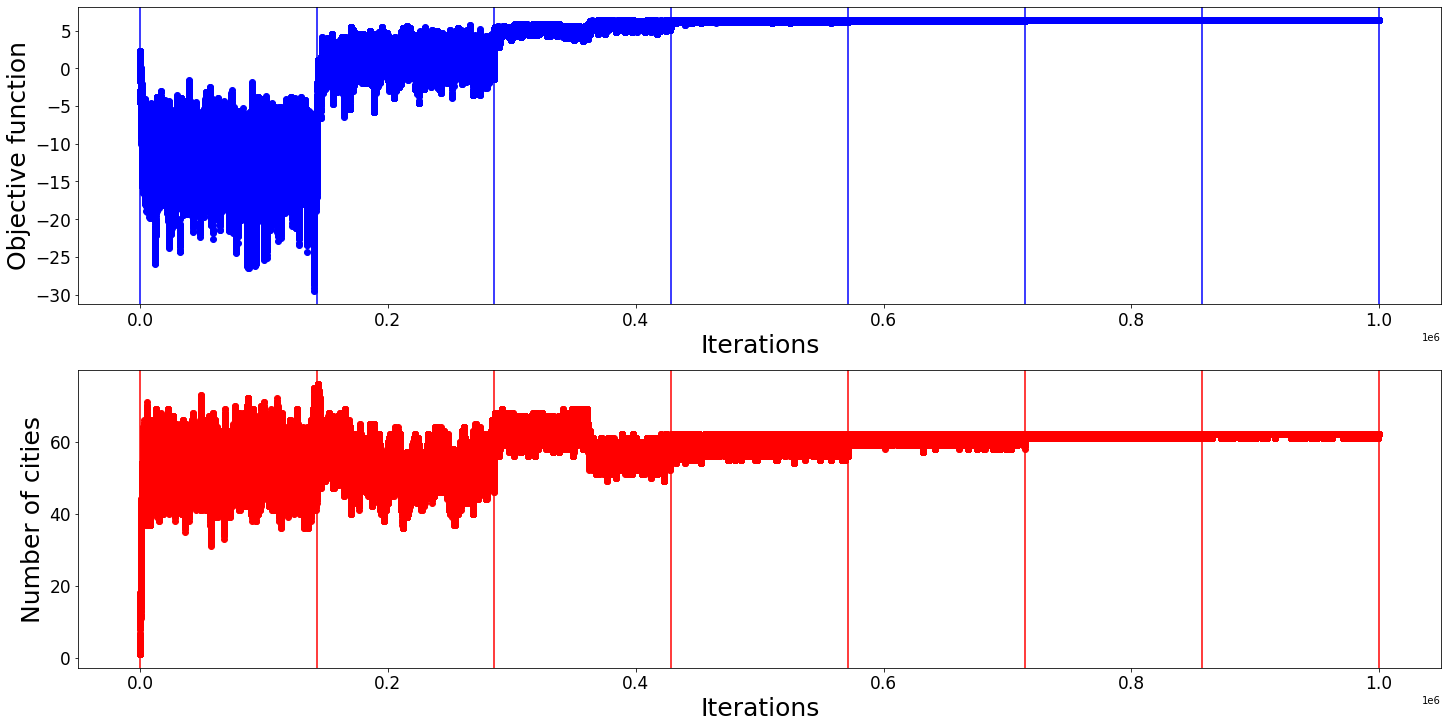

In [60]:
data = G1()
lambda_ = 0.5
starting_state = np.zeros(data.N) 
starting_state[ data.v == np.max(data.v)] = 1

S_approx = simulated_annealing(starting_state, betas, n_iter, lambda_, data, verbose=False, plot=True)

# Ploting the evolution of the average approximation with respect to lambda  (with G1, Q2.b)

In [61]:
G = G1 
nb_instances = 5
lambdas = np.linspace(0, 1, 10)

plot_avg_lambda(G, lambdas, betas, n_iter, nb_instances, verbose=False)

KeyboardInterrupt: 

# Ploting the evolution of the Markov chain during the simulated annealing process (with G2, Q3.a)

In [ ]:
data = G2()
lambda_ = 1
starting_state = np.zeros(data.N) 
starting_state[ data.v == np.max(data.v)] = 1

S_approx = simulated_annealing(starting_state, betas, n_iter, lambda_, data, verbose=False, plot=True)

# Ploting the evolution of the average approximation with respect to lambda  (with G2, Q3.b)

In [ ]:
G = G2
nb_instances = 5
lambdas = np.linspace(0, 2, 10)

plot_avg_lambda(G, lambdas, betas, n_iter, nb_instances, verbose=False)